## Preparación

In [ ]:
%%capture
#@title Instalamos gym
!pip install swig
!pip install "gymnasium[box2d]"
!pip install numpy
!pip install matplotlib
!pip install tqdm
#!pip install "gymnasium[toy-text]"
!pip install Box2D
!pip install pygame


In [ ]:
#@title Importamos librerias
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import Box2D
import random

In [ ]:
#@title Importamos el lago helado
name = 'Taxi-v3'

# Creamos el entorno Taxi-v3
env = gym.make(name, render_mode="rgb_array")


In [ ]:
# Política Greedy a partir de los valores Q. Se usa para mostrar la solución.
def pi_star_from_Q(env, Q):
    frames = []
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset(seed=seed)  # start in top-left, = 0
    img = env.render()
    frames.append(img)
    actions = ""
    
    while not done:
        # Obtener los valores Q para el estado actual y encontrar la mejor acción
        q_values = Q[state]  # Q es un defaultdict, esto retorna el array de valores para el estado
        action = np.argmax(q_values)
        
        # Registrar la acción
        actions += f"{action}, "
        pi_star[state, action] = action
        
        # Ejecutar la acción en el ambiente
        state, reward, terminated, truncated, info = env.step(action)
        img = env.render()
        frames.append(img)
        done = terminated or truncated
    
    return pi_star, actions, frames

In [ ]:
import matplotlib.pyplot as plt

def plot(list_stats, episode_sizes, window_size=100):
    # Creamos una lista de índices para el eje x
    indices = list(range(len(list_stats)))

    # Función para calcular la media móvil
    def calculate_moving_avg(data, window_size):
        moving_avg = []
        for i in range(len(data)):
            if i < window_size:
                moving_avg.append(sum(data[:i+1]) / (i+1))
            else:
                moving_avg.append(sum(data[i-window_size:i+1]) / window_size)
        return moving_avg

    # Calculamos la media móvil para la proporción de recompensas
    moving_avg_rewards = calculate_moving_avg(list_stats, window_size)

    # Calculamos la media móvil para el tamaño del episodio
    moving_avg_sizes = calculate_moving_avg(episode_sizes, window_size)

    # Creamos el gráfico de la proporción de recompensas y la media móvil
    plt.figure(figsize=(12, 6))

    # Gráfico de la proporción de recompensas y la media móvil
    plt.subplot(2, 1, 1)
    plt.plot(indices, list_stats, label='Proporción de recompensas', alpha=0.3, color='blue')  # Más transparente
    plt.plot(indices, moving_avg_rewards, label=f'Media móvil (ventana={window_size})', color='red', linewidth=2)  # Más opaco
    plt.title('Proporción de recompensas y Media Móvil')
    plt.xlabel('Episodio')
    plt.ylabel('Proporción')
    plt.legend()
    plt.grid(True)

    # Gráfico del tamaño del episodio y su media móvil
    plt.subplot(2, 1, 2)
    plt.plot(indices, episode_sizes, label='Tamaño del episodio', alpha=0.3, color='green')  # Más transparente
    plt.plot(indices, moving_avg_sizes, label=f'Media móvil (ventana={window_size})', color='orange', linewidth=2)  # Más opaco
    plt.title('Tamaño del Episodio y Media Móvil')
    plt.xlabel('Episodio')
    plt.ylabel('Tamaño')
    plt.legend()
    plt.grid(True)

    # Ajustamos el espacio entre los subplots
    plt.tight_layout()

    # Mostramos los gráficos
    plt.show()

In [ ]:
import os 
import gc 
import torch 
import numpy as np 
import gymnasium as gym

# Configuración del dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"Usando dispositivo: {device}")

# Liberación de memoria para evitar problemas de consumo en GPU
gc.collect() # Ejecuta el recolector de basura de Python
torch.cuda.empty_cache() # Vacía la caché de memoria en GPU

# Depuración de errores en CUDA
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # Muestra errores de CUDA en el punto exacto donde ocurren

# Configuración de la semilla para reproducibilidad 
seed = 2024 # Se define una semilla fija

# Fijar la semilla en NumPy 
np.random.seed(seed) # Para generar números aleatorios consistentes en NumPy 
np.random.default_rng(seed) # Establece una instancia del generador de NumPy con la misma semilla 

# Fijar la semilla en Python 
os.environ['PYTHONHASHSEED'] = str(seed) # Evita variabilidad en hashing de Python

# Fijar la semilla en PyTorch 
torch.manual_seed(seed) # Asegura resultados reproducibles en operaciones de PyTorch
 
if torch.cuda.is_available(): # Si hay GPU disponible 
    torch.cuda.manual_seed(seed) # Fija la semilla para la GPU 
    torch.backends.cudnn.deterministic = True # Hace las operaciones de CUDNN determinísticas 
    torch.backends.cudnn.benchmark = False # Desactiva optimizaciones de CUDNN para evitar variabilidad

Usando dispositivo: cuda


In [ ]:
from moviepy import ImageSequenceClip  # pip install moviepy
def create_gif(frames: list, filename, fps=5):
   """
   Creates a GIF animation from a list of RGBA NumPy arrays.
   Args:
       frames: A list of RGBA NumPy arrays representing the animation frames.
       filename: The output filename for the GIF animation.
       fps: The frames per second of the animation (default: 10).
   """
   clip = ImageSequenceClip(frames, fps=fps)
   clip.write_videofile(filename, fps=fps)

## Temporales

### Q-Learning

In [ ]:
import numpy as np
from collections import defaultdict
import random

class QLearningAgent:
    def __init__(self, env, eps=1, decay = True, gamma=0.99, alpha=0.2):
        """Initialize agent.
        
        Params
        ======
        - env: Gymnasium environment
        - eps: exploration rate
        - gamma: discount factor
        - alpha: learning rate
        """
        self.env = env
        self.eps = eps
        self.gamma = gamma
        self.alpha = alpha
        self.decay = decay
        
        # Initialize Q-table based on action space, not observation space
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
        
    def epsilon_greedy(self, state):
        """Epsilon-greedy action selection."""
        if random.random() > self.eps:  # select greedy action with probability 1-epsilon
            return np.argmax(self.Q[state])
        else:  # select random action with probability epsilon
            return random.randint(0, self.env.action_space.n - 1)
    
    def get_action(self, state, episode):
        if self.decay:
            self.eps = min(1.0, 1000.0 / (episode + 1))
        """Select an action given the current state."""
        return self.epsilon_greedy(state)
    
    def update(self, state, action, reward, next_state, done):
        """Update the agent's knowledge using the most recently sampled tuple.
        
        Params
        ======
        - state: the previous state of the environment
        - action: the agent's previous choice of action
        - reward: last reward received
        - next_state: the current state of the environment
        - done: whether the episode is complete (True or False)
        """
        # Current Q-value
        current = self.Q[state][action]
        
        # Next state's maximum Q-value
        if done:
            Qsa_next = 0  # Terminal state has no future value
        else:
            Qsa_next = np.max(self.Q[next_state])
        
        # Q-learning update
        target = reward + (self.gamma * Qsa_next)
        self.Q[state][action] = current + (self.alpha * (target - current))

In [ ]:
agent = QLearningAgent(env)
    
# Listas para guardar métricas
rewards_per_episode = []
episodes_sizes = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = 20000 / 10

# Bucle de entrenamiento
for episode in tqdm(range(20000)):
    obs, info = env.reset(seed=seed)
    done = False
    episode_reward = 0
    episode_steps = 0
    
    while not done:
        action = agent.get_action(obs, episode)  # Cambiado de get_action a select_action para mantener consistencia
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        # Actualizar el agente
        agent.update(obs, action, reward, next_obs, terminated)  # Usando el método step definido anteriormente
        
        # Actualizar estado y métricas
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1
        
    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats/(episode+1))
    
    # Guardar métricas del episodio
    rewards_per_episode.append(episode_reward)
    episodes_sizes.append(episode_steps)
    
    # Para mostrar la evolución.  Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"success: {stats/episode}, epsilon: {agent.eps}")


 11%|█▏        | 2289/20000 [00:05<00:11, 1565.64it/s]

success: -486.4635, epsilon: 0.49975012493753124


 22%|██▏       | 4458/20000 [00:06<00:06, 2574.55it/s]

success: -251.5685, epsilon: 0.24993751562109473


 31%|███▏      | 6290/20000 [00:07<00:04, 3057.47it/s]

success: -168.60516666666666, epsilon: 0.16663889351774705


 42%|████▏     | 8494/20000 [00:08<00:03, 3134.47it/s]

success: -126.1545, epsilon: 0.1249843769528809


 53%|█████▎    | 10503/20000 [00:08<00:03, 2633.54it/s]

success: -100.2872, epsilon: 0.0999900009999


 63%|██████▎   | 12519/20000 [00:09<00:02, 3361.15it/s]

success: -82.82458333333334, epsilon: 0.08332638946754437


 73%|███████▎  | 14572/20000 [00:10<00:01, 3354.54it/s]

success: -70.21842857142857, epsilon: 0.07142346975216056


 83%|████████▎ | 16604/20000 [00:10<00:01, 3263.38it/s]

success: -60.7374375, epsilon: 0.06249609399412537


 92%|█████████▏| 18438/20000 [00:11<00:00, 2545.14it/s]

success: -53.31922222222222, epsilon: 0.05555246930726071


100%|██████████| 20000/20000 [00:12<00:00, 1636.28it/s]


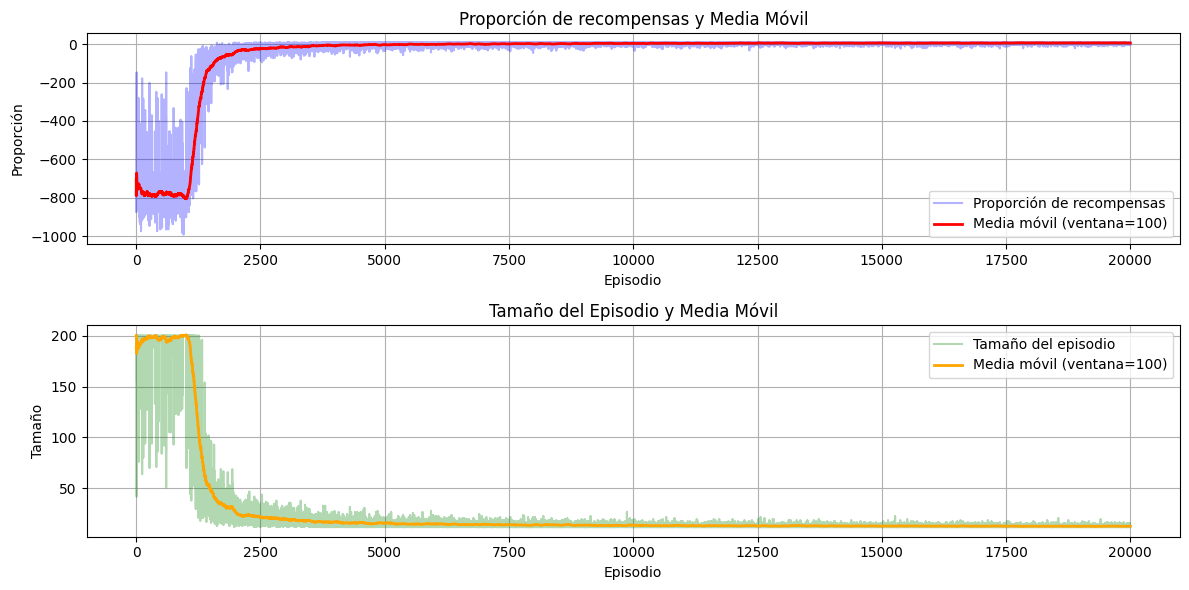

In [ ]:
plot(rewards_per_episode, episodes_sizes)

In [ ]:
pi, actions, frames = pi_star_from_Q(env, agent.Q)

img = env.render()

frames.append(img)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env.render() )
print()

Política óptima obtenida
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 1, 2, 2, 0, 0, 4, 1, 1, 1, 1, 2, 5,  
 Para el siguiente grid
 [[[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[114 116 115]
  [114 116 115]
  [126 127 126]
  ...
  [112 113 111]
  [112 113 111]
  [118 117 115]]

 ...

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[115 112 112]
  [115 112 112]
  [119 119 117]
  ...
  [123 119 118]
  [123 119 118]
  [114 114 117]]]



In [ ]:
# Example usage
create_gif(frames, "Q-Learning.mp4", fps=1)  # saves the GIF locally

MoviePy - Building video Q-Learning.mp4.
MoviePy - Writing video Q-Learning.mp4



MoviePy - Done !
MoviePy - video ready Q-Learning.mp4


### Sarsa


In [ ]:
import numpy as np
from collections import defaultdict
import random

class SarsaAgent:
    def __init__(self, env, eps=0.4, decay = True, gamma=0.99, alpha=0.2):
        """Initialize agent.
        
        Params
        ======
        - env: Gymnasium environment
        - eps: exploration rate
        - gamma: discount factor
        - alpha: learning rate
        """
        self.env = env
        self.eps = eps
        self.gamma = gamma
        self.alpha = alpha
        self.decay = decay
        
        # Initialize Q-table based on action space, not observation space
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
        
    def epsilon_greedy(self, state):
        """Epsilon-greedy action selection."""
        if random.random() > self.eps:  # select greedy action with probability 1-epsilon
            return np.argmax(self.Q[state])
        else:  # select random action with probability epsilon
            return random.randint(0, self.env.action_space.n - 1)
    
    def get_action(self, state, episode):
        if self.decay:
            self.eps = min(1.0, 1000.0 / (episode + 1))
        """Select an action given the current state."""
        return self.epsilon_greedy(state)
    
    def update(self, state, action, reward, next_state, done):
        """Update the agent's knowledge using the most recently sampled tuple.
        
        Params
        ======
        - state: the previous state of the environment
        - action: the agent's previous choice of action
        - reward: last reward received
        - next_state: the current state of the environment
        - done: whether the episode is complete (True or False)
        """
        # Current Q-value
        current = self.Q[state][action]
        
        # Next state's maximum Q-value
        if done:
            Qsa_next = 0  # Terminal state has no future value
        else:
            next_action = self.epsilon_greedy(next_state)
            Qsa_next = self.Q[next_state][next_action]
        
        # Sarsa update
        target = reward + (self.gamma * Qsa_next)
        self.Q[state][action] = current + (self.alpha * (target - current))

In [ ]:
agent = SarsaAgent(env)
    
# Listas para guardar métricas
rewards_per_episode = []
episodes_sizes = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = 20000 / 10

# Bucle de entrenamiento
for episode in tqdm(range(20000)):
    obs, info = env.reset(seed=seed)
    done = False
    episode_reward = 0
    episode_steps = 0
    
    while not done:
        action = agent.get_action(obs, episode)  # Cambiado de get_action a select_action para mantener consistencia
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        # Actualizar el agente
        agent.update(obs, action, reward, next_obs, terminated)  # Usando el método step definido anteriormente
        
        # Actualizar estado y métricas
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1
        
    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats/(episode+1))
    
    # Guardar métricas del episodio
    rewards_per_episode.append(episode_reward)
    episodes_sizes.append(episode_steps)
    
    # Para mostrar la evolución.  Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"success: {stats/episode}, epsilon: {agent.eps}")


 12%|█▏        | 2476/20000 [00:04<00:08, 2036.34it/s]

success: -495.6405, epsilon: 0.49975012493753124


 22%|██▏       | 4403/20000 [00:04<00:05, 3115.31it/s]

success: -257.2975, epsilon: 0.24993751562109473


 33%|███▎      | 6660/20000 [00:05<00:03, 3798.61it/s]

success: -172.8415, epsilon: 0.16663889351774705


 44%|████▎     | 8724/20000 [00:05<00:02, 4068.86it/s]

success: -129.48725, epsilon: 0.1249843769528809


 54%|█████▍    | 10848/20000 [00:06<00:02, 4192.97it/s]

success: -103.0118, epsilon: 0.0999900009999


 63%|██████▎   | 12601/20000 [00:06<00:01, 4356.10it/s]

success: -85.17091666666667, epsilon: 0.08332638946754437


 74%|███████▍  | 14867/20000 [00:07<00:01, 4511.16it/s]

success: -72.3075, epsilon: 0.07142346975216056


 83%|████████▎ | 16639/20000 [00:07<00:00, 4296.19it/s]

success: -62.60475, epsilon: 0.06249609399412537


 94%|█████████▍| 18895/20000 [00:08<00:00, 4457.43it/s]

success: -55.011833333333335, epsilon: 0.05555246930726071


100%|██████████| 20000/20000 [00:08<00:00, 2371.32it/s]


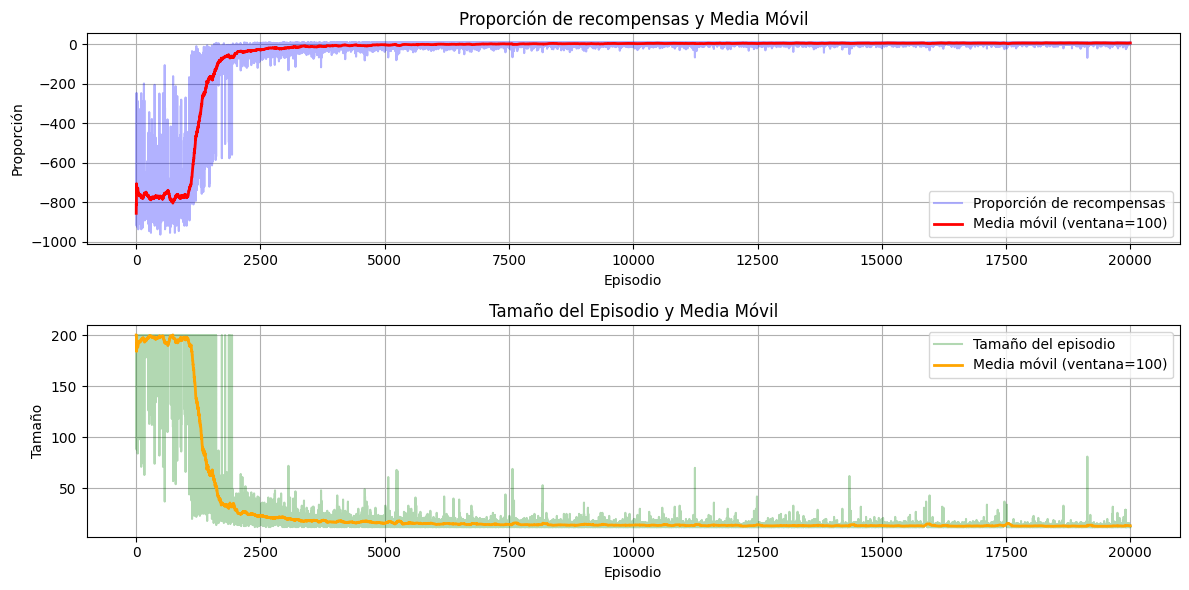

In [ ]:
plot(rewards_per_episode, episodes_sizes)

In [ ]:
pi, actions, frames = pi_star_from_Q(env, agent.Q)

img = env.render()

frames.append(img)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env.render() )
print()

Política óptima obtenida
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 2, 1, 2, 0, 0, 4, 1, 2, 1, 1, 1, 5,  
 Para el siguiente grid
 [[[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[114 116 115]
  [114 116 115]
  [126 127 126]
  ...
  [112 113 111]
  [112 113 111]
  [118 117 115]]

 ...

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[115 112 112]
  [115 112 112]
  [119 119 117]
  ...
  [123 119 118]
  [123 119 118]
  [114 114 117]]]



In [ ]:
# Example usage
create_gif(frames, "Sarsa.mp4", fps=1)  # saves the GIF locally

MoviePy - Building video Sarsa.mp4.
MoviePy - Writing video Sarsa.mp4



MoviePy - Done !
MoviePy - video ready Sarsa.mp4


## Monte Carlo


### Off-policy

In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

# Hiperparámetros
NUM_EPISODES = 20000
GAMMA = 0.99  # Factor de descuento
EPSILON = 1.0  # Probabilidad de exploración
EPSILON_DECAY = 0.999
MIN_EPSILON = 0.001

# Clase MonteCarloOffPolicyAgent
class MonteCarloOffPolicyAgent:
    def __init__(self, env, gamma, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.C = np.zeros((self.env.observation_space.n, self.env.action_space.n))  # Suma de pesos de Importance Sampling

    # Política de comportamiento (ε-greedy)
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración: acción aleatoria
        else:
            return np.argmax(self.Q[state])  # Explotación: mejor acción según Q

    # Actualizar la tabla Q usando Monte Carlo Off-Policy
    def update(self, episode):
        G = 0  # Retorno total
        W = 1  # Peso de Importance Sampling

        # Recorrer el episodio en reversa
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = self.gamma * G + reward
            self.C[state, action] += W
            self.Q[state, action] += (W / self.C[state, action]) * (G - self.Q[state, action])

            # Si la acción no es la óptima según la política objetivo, terminar el episodio
            if action != np.argmax(self.Q[state]):
                break

            W = W * 1.0 / (self.epsilon / self.env.action_space.n + (1 - self.epsilon) * (action == np.argmax(self.Q[state])))

        # Decaimiento de ε
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

In [ ]:
# Inicializar el agente
agent = MonteCarloOffPolicyAgent(
    env=env,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode = []
episodes_sizes = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env.reset(seed=seed)
    done = False
    episode_reward = 0
    episode_steps = 0
    episode_data = []

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        # Guardar datos del episodio
        episode_data.append((obs, action, reward))
        
        # Actualizar estado y métricas
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1

    # Actualizar el agente con el episodio completo
    agent.update(episode_data)

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode.append(episode_reward)
    episodes_sizes.append(episode_steps)

    # Para mostrar la evolución. Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

# Cerrar el entorno
env.close()

 12%|█▏        | 2314/20000 [00:03<00:07, 2441.85it/s]

Éxito promedio: -258.972, Épsilon: 0.13506472547210188


 21%|██▏       | 4278/20000 [00:04<00:05, 3050.57it/s]

Éxito promedio: -127.54625, Épsilon: 0.018260740807661956


 31%|███▏      | 6291/20000 [00:04<00:04, 3316.06it/s]

Éxito promedio: -82.81516666666667, Épsilon: 0.0024688507948989738


 42%|████▏     | 8375/20000 [00:05<00:03, 3446.91it/s]

Éxito promedio: -60.376375, Épsilon: 0.001


 52%|█████▏    | 10438/20000 [00:06<00:02, 3375.76it/s]

Éxito promedio: -46.9098, Épsilon: 0.001


 62%|██████▏   | 12469/20000 [00:06<00:02, 3349.26it/s]

Éxito promedio: -37.933416666666666, Épsilon: 0.001


 73%|███████▎  | 14541/20000 [00:07<00:01, 3452.05it/s]

Éxito promedio: -31.52092857142857, Épsilon: 0.001


 83%|████████▎ | 16619/20000 [00:07<00:00, 3426.47it/s]

Éxito promedio: -26.71175, Épsilon: 0.001


 92%|█████████▏| 18357/20000 [00:08<00:00, 3400.79it/s]

Éxito promedio: -22.973333333333333, Épsilon: 0.001


100%|██████████| 20000/20000 [00:08<00:00, 2230.67it/s]


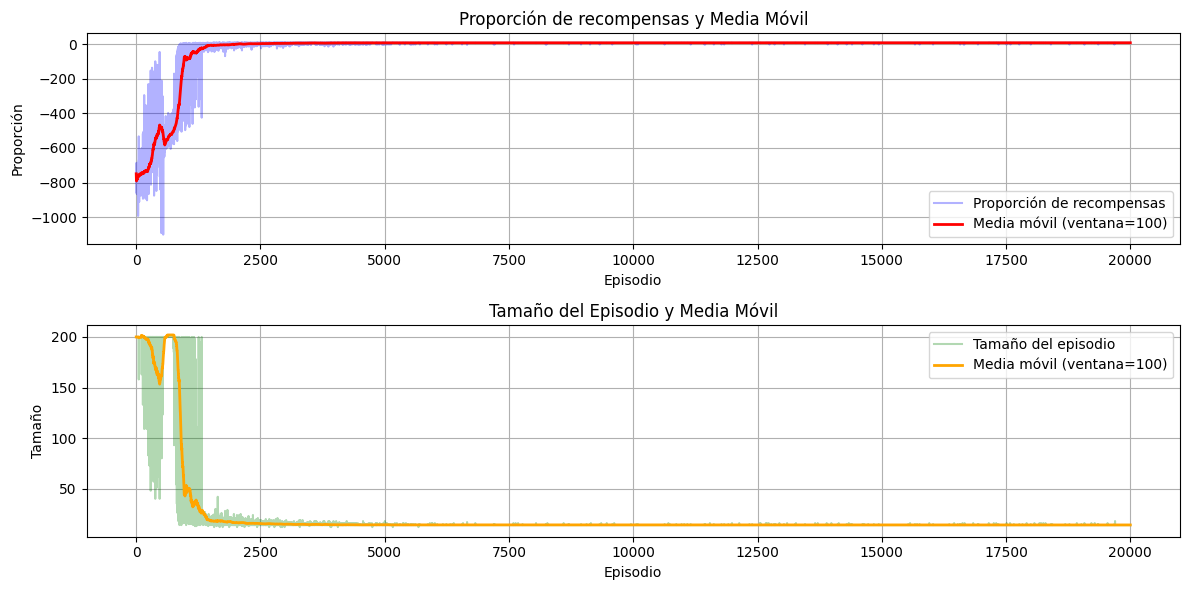

In [ ]:
plot(rewards_per_episode, episodes_sizes)

In [ ]:
pi, actions, frames = pi_star_from_Q(env, agent.Q)

img = env.render()

frames.append(img)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env.render() )
print()

Política óptima obtenida
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 2, 1, 2, 2, 0, 3, 0, 4, 1, 1, 2, 1, 1, 5,  
 Para el siguiente grid
 [[[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[114 116 115]
  [114 116 115]
  [126 127 126]
  ...
  [112 113 111]
  [112 113 111]
  [118 117 115]]

 ...

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[115 112 112]
  [115 112 112]
  [119 119 117]
  ...
  [123 119 118]
  [123 119 118]
  [114 114 117]]]



In [ ]:
# Example usage
create_gif(frames, "MCOffPolicy.mp4", fps=1)  # saves the GIF locally

MoviePy - Building video MCOffPolicy.mp4.
MoviePy - Writing video MCOffPolicy.mp4



MoviePy - Done !
MoviePy - video ready MCOffPolicy.mp4


### On-policy

In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

# Hiperparámetros
NUM_EPISODES = 20000
GAMMA = 0.99  # Factor de descuento
EPSILON = 1.0  # Probabilidad de exploración
EPSILON_DECAY = 0.999
MIN_EPSILON = 0.001

# Clase MonteCarloOffPolicyAgent
class MonteCarloOnPolicyAgent:
    def __init__(self, env, gamma, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))

    # Política de comportamiento (ε-greedy)
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración: acción aleatoria
        else:
            return np.argmax(self.Q[state])  # Explotación: mejor acción según Q

    # Actualizar la tabla Q usando Monte Carlo On-Policy
    def update(self, episode):
        states, actions, rewards = zip(*episode)
        G = 0  # Retorno total

        # Recorrer el episodio en reversa
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = self.gamma * G + reward

            # Actualizar el Q-value para el par (state, action)
            self.Q[state, action] += (G - self.Q[state, action]) / (t + 1)  # Promedio incremental

        # Decaimiento de ε
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

In [ ]:
# Inicializar el agente
agent = MonteCarloOnPolicyAgent(
    env=env,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode = []
episodes_sizes = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env.reset(seed=seed)
    done = False
    episode_reward = 0
    episode_steps = 0
    episode_data = []

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        # Guardar datos del episodio
        episode_data.append((obs, action, reward))
        
        # Actualizar estado y métricas
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1

    # Actualizar el agente con el episodio completo
    agent.update(episode_data)

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode.append(episode_reward)
    episodes_sizes.append(episode_steps)

    # Para mostrar la evolución. Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

 10%|█         | 2081/20000 [00:03<00:20, 881.81it/s]

Éxito promedio: -103.911, Épsilon: 0.13506472547210188


 20%|██        | 4064/20000 [00:06<00:29, 541.93it/s]

Éxito promedio: -49.82475, Épsilon: 0.018260740807661956


 30%|███       | 6053/20000 [00:11<00:36, 385.46it/s]

Éxito promedio: -30.466833333333334, Épsilon: 0.0024688507948989738


 40%|████      | 8059/20000 [00:17<00:40, 296.63it/s]

Éxito promedio: -20.616125, Épsilon: 0.001


 50%|█████     | 10032/20000 [00:25<00:45, 217.25it/s]

Éxito promedio: -14.698, Épsilon: 0.001


 60%|██████    | 12038/20000 [00:36<00:43, 182.29it/s]

Éxito promedio: -10.773916666666667, Épsilon: 0.001


 70%|███████   | 14017/20000 [00:49<00:51, 115.62it/s]

Éxito promedio: -7.955785714285715, Épsilon: 0.001


 80%|████████  | 16005/20000 [01:05<00:35, 111.96it/s]

Éxito promedio: -5.8395, Épsilon: 0.001


 90%|█████████ | 18016/20000 [01:22<00:17, 112.05it/s]

Éxito promedio: -4.1955, Épsilon: 0.001


100%|██████████| 20000/20000 [01:41<00:00, 196.36it/s]


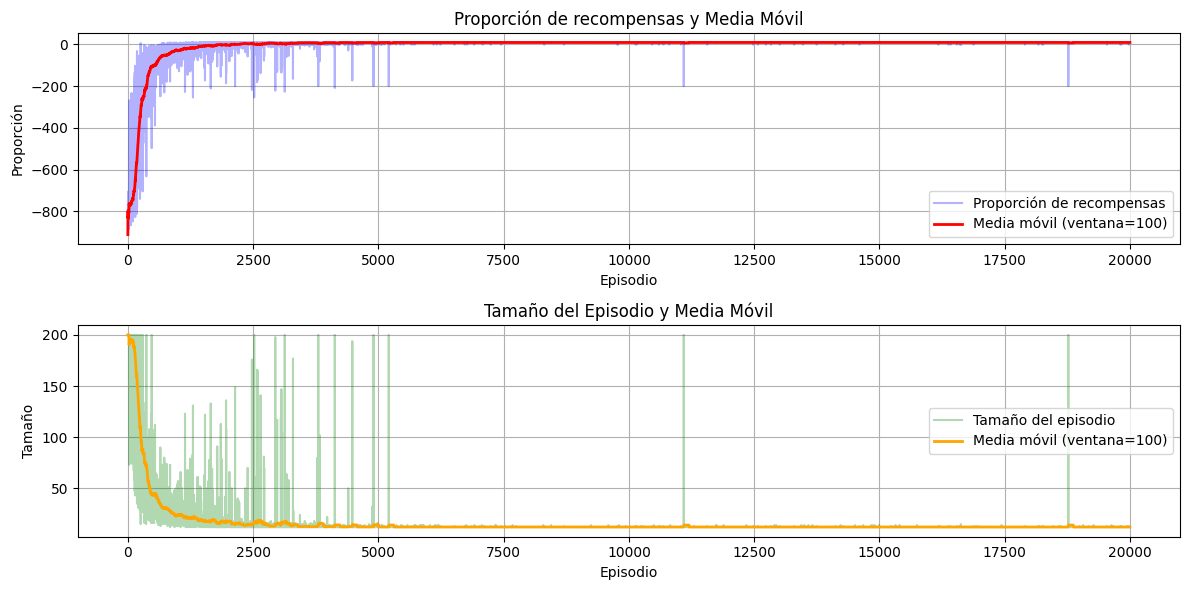

In [ ]:
plot(rewards_per_episode, episodes_sizes)

In [ ]:
pi, actions, frames = pi_star_from_Q(env, agent.Q)

img = env.render()

frames.append(img)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env.render() )
print()

Política óptima obtenida
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 2, 1, 2, 0, 0, 4, 2, 1, 1, 1, 1, 5,  
 Para el siguiente grid
 [[[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[114 116 115]
  [114 116 115]
  [126 127 126]
  ...
  [112 113 111]
  [112 113 111]
  [118 117 115]]

 ...

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[115 112 112]
  [115 112 112]
  [119 119 117]
  ...
  [123 119 118]
  [123 119 118]
  [114 114 117]]]



In [ ]:
# Example usage
create_gif(frames, "MCOnPolicy.mp4", fps=1)  # saves the GIF locally

MoviePy - Building video MCOnPolicy.mp4.
MoviePy - Writing video MCOnPolicy.mp4



MoviePy - Done !
MoviePy - video ready MCOnPolicy.mp4


## Control con Aproximaciones

### Sarsa Semi-gradiente

In [ ]:
# Hiperparámetros
NUM_EPISODES = 20000
GAMMA = 0.99  # Factor de descuento
ALPHA = 0.01  # Tasa de aprendizaje
EPSILON = 1.0  # Probabilidad de exploración
EPSILON_DECAY = 0.999
MIN_EPSILON = 0.01

# Clase SarsaSemiGradientAgent
class SarsaSemiGradientAgent:
    def __init__(self, env, gamma, alpha, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Inicializar los pesos de la función de valor Q(s, a)
        self.num_states = env.observation_space.n
        self.num_actions = env.action_space.n
        self.weights = np.zeros((self.num_states, self.num_actions))  # Pesos para la aproximación lineal

    # Política ε-greedy
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)  # Exploración: acción aleatoria
        else:
            return np.argmax(self.Q(state))  # Explotación: mejor acción según Q

    # Aproximación lineal de Q(s, a)
    def Q(self, state):
        return self.weights[state]  # Q(s, a) = weights[s, a]

    # Actualizar los pesos usando SARSA Semi-Gradiente
    def update(self, state, action, reward, next_state, next_action, done):
        if done:
            target = reward  # Si el episodio termina, el valor objetivo es la recompensa inmediata
        else:
            target = reward + self.gamma * self.Q(next_state)[next_action]  # Valor objetivo para SARSA

        # Calcular el error temporal
        td_error = target - self.Q(state)[action]

        # Actualizar los pesos usando el gradiente
        self.weights[state, action] += self.alpha * td_error

        # Decaimiento de ε
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

In [ ]:
# Inicializar el agente
agent = SarsaSemiGradientAgent(
    env=env,
    gamma=GAMMA,
    alpha=ALPHA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode = []
episodes_sizes = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env.reset(seed=seed)
    done = False
    episode_reward = 0
    episode_steps = 0

    # Seleccionar la primera acción
    action = agent.get_action(obs)

    while not done:
        # Tomar la acción y observar el siguiente estado y recompensa
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        # Seleccionar la siguiente acción
        next_action = agent.get_action(next_obs)
        
        # Actualizar el agente
        agent.update(obs, action, reward, next_obs, next_action, terminated)
        
        # Actualizar estado y métricas
        obs = next_obs
        action = next_action
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode.append(episode_reward)
    episodes_sizes.append(episode_steps)

    # Para mostrar la evolución. Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"Éxito promedio: {stats / episode}, Épsilon: {agent.epsilon}")

 15%|█▍        | 2904/20000 [00:01<00:04, 4082.06it/s]

Éxito promedio: -27.668, Épsilon: 0.01


 23%|██▎       | 4659/20000 [00:01<00:03, 4102.95it/s]

Éxito promedio: -9.59225, Épsilon: 0.01


 34%|███▍      | 6896/20000 [00:02<00:02, 4437.13it/s]

Éxito promedio: -3.5508333333333333, Épsilon: 0.01


 43%|████▎     | 8688/20000 [00:02<00:02, 3847.94it/s]

Éxito promedio: -0.531, Épsilon: 0.01


 54%|█████▍    | 10857/20000 [00:03<00:02, 4082.69it/s]

Éxito promedio: 1.27, Épsilon: 0.01


 63%|██████▎   | 12664/20000 [00:03<00:01, 4448.20it/s]

Éxito promedio: 2.474, Épsilon: 0.01


 75%|███████▍  | 14962/20000 [00:04<00:01, 4572.34it/s]

Éxito promedio: 3.3353571428571427, Épsilon: 0.01


 84%|████████▍ | 16835/20000 [00:04<00:00, 4604.89it/s]

Éxito promedio: 3.9904375, Épsilon: 0.01


 94%|█████████▎| 18749/20000 [00:05<00:00, 4678.83it/s]

Éxito promedio: 4.504111111111111, Épsilon: 0.01


100%|██████████| 20000/20000 [00:05<00:00, 3777.64it/s]


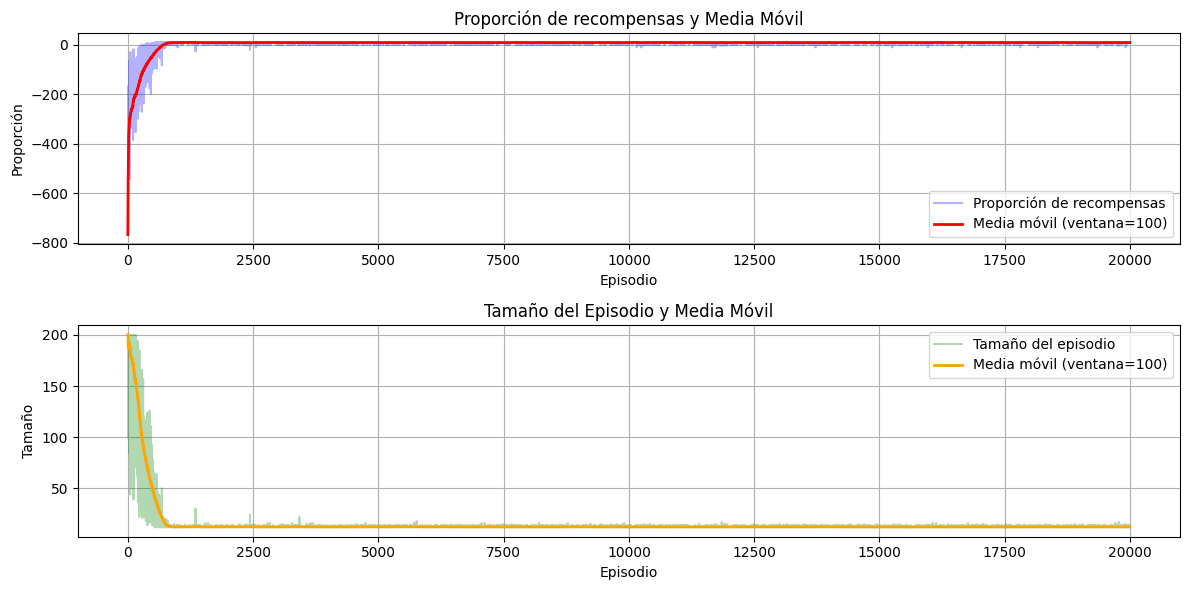

In [ ]:
plot(rewards_per_episode, episodes_sizes)

In [ ]:
pi, actions, frames = pi_star_from_Q(env, agent.weights)

img = env.render()

frames.append(img)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env.render() )
print()

Política óptima obtenida
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 1, 2, 2, 0, 0, 4, 1, 2, 1, 1, 1, 5,  
 Para el siguiente grid
 [[[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[114 116 115]
  [114 116 115]
  [126 127 126]
  ...
  [112 113 111]
  [112 113 111]
  [118 117 115]]

 ...

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[115 112 112]
  [115 112 112]
  [119 119 117]
  ...
  [123 119 118]
  [123 119 118]
  [114 114 117]]]

